In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [27]:
def load_and_preprocess_emails(email_file, department_file):
    # 解压并读取email文件
    with gzip.open(email_file, 'rt') as f:
        email_data = [line.strip().split() for line in f]

        # 解压并读取department文件
    with gzip.open(department_file, 'rt') as f:
        department_data = [line.strip().split() for line in f]

        # 假设email_data和department_data的格式为 [identifier, info]，我们创建一个字典来存储信息
    email_dict = {row[0]: row[1] for row in email_data}
    department_dict = {row[0]: row[1] for row in department_data}

    # 合并两个字典（如果两个文件有共同的标识符）
    combined_data = {}
    for identifier, info in email_dict.items():
        combined_data[identifier] = {'email_info': info}
        if identifier in department_dict:
            combined_data[identifier]['department'] = department_dict[identifier]

            # 转换字典为列表，类似于您之前的二维表到一维列表的转换
    processed_data = []
    for identifier, info_dict in combined_data.items():
        datarow = [('identifier', identifier)]
        for key, value in info_dict.items():
            datarow.append((key, value))
        processed_data.append(datarow)

    return processed_data



# 调用函数并传入文件路径
email_file_path = 'email-Eu-core.txt.gz'
department_file_path = 'email-Eu-core-department-labels.txt.gz'
data_set = load_and_preprocess_emails(email_file_path, department_file_path)

for row in data_set:
    print(row)



[('identifier', '0'), ('email_info', '166'), ('department', '1')]
[('identifier', '2'), ('email_info', '1001'), ('department', '21')]
[('identifier', '5'), ('email_info', '230'), ('department', '25')]
[('identifier', '8'), ('email_info', '301'), ('department', '14')]
[('identifier', '10'), ('email_info', '282'), ('department', '9')]
[('identifier', '12'), ('email_info', '638'), ('department', '14')]
[('identifier', '15'), ('email_info', '160'), ('department', '17')]
[('identifier', '17'), ('email_info', '932'), ('department', '1')]
[('identifier', '20'), ('email_info', '271'), ('department', '9')]
[('identifier', '23'), ('email_info', '421'), ('department', '11')]
[('identifier', '41'), ('email_info', '918'), ('department', '5')]
[('identifier', '43'), ('email_info', '498'), ('department', '14')]
[('identifier', '45'), ('email_info', '933'), ('department', '17')]
[('identifier', '47'), ('email_info', '925'), ('department', '10')]
[('identifier', '49'), ('email_info', '83'), ('departmen

In [28]:
# 创建1-频繁项集的候选集
def create_C1(data_set):
    C1 = set()
    for t in data_set:
        for item in t:
            item_set = frozenset([item])
            C1.add(item_set)
    return C1

# 判断候选集是否满足apriori规则
def is_apriori(Ck_item, Lksub1):
    for item in Ck_item:
        sub_Ck = Ck_item - frozenset([item])
        if sub_Ck not in Lksub1:
            return False
    return True


In [29]:
# 创建k-频繁项集的候选集
def create_Ck(Lksub1, k):
    Ck = set()
    len_Lksub1 = len(Lksub1)
    list_Lksub1 = list(Lksub1)
    for i in range(len_Lksub1):
        for j in range(1, len_Lksub1):
            l1 = list(list_Lksub1[i])
            l2 = list(list_Lksub1[j])
            l1.sort()
            l2.sort()
            if l1[0:k - 2] == l2[0:k - 2]:
                Ck_item = list_Lksub1[i] | list_Lksub1[j]
                if is_apriori(Ck_item, Lksub1):
                    Ck.add(Ck_item)
    return Ck

In [31]:
# 由k-频繁项集候选集生成实际的频繁项集
def generate_Lk_by_Ck(data_set, Ck, min_support, support_data):
    Lk = set()
    item_count = {}
    for t in data_set:
        for item in Ck:
            if item.issubset(t):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1
    t_num = float(len(data_set))
    for item in item_count:
        if (item_count[item] / t_num) >= min_support:
            Lk.add(item)
            support_data[item] = item_count[item] / t_num
    return Lk


# 生成从1-频繁项集到k-频繁项集的全集
def generate_L(data_set, k, min_support):
    support_data = {}
    C1 = create_C1(data_set)
    L1 = generate_Lk_by_Ck(data_set, C1, min_support, support_data)
    Lksub1 = L1.copy()
    L = []
    L.append(Lksub1)
    for i in range(2, k + 1):
        Ci = create_Ck(Lksub1, i)
        Li = generate_Lk_by_Ck(data_set, Ci, min_support, support_data)
        Lksub1 = Li.copy()
        L.append(Lksub1)
    
    return L, support_data

L, support_data = generate_L(data_set, k=3, min_support=0.005)


In [33]:
# 由频繁项集挖掘关联规则
def generate_rules(L, support_data, min_conf):
    rules_list = []
    sub_set_list = []
    for i in range(0, len(L)):
        for freq_set in L[i]:
            for sub_set in sub_set_list:
                if sub_set.issubset(freq_set):
                    conf = support_data[freq_set] / support_data[freq_set - sub_set]
                    rule = (freq_set - sub_set, sub_set, conf)
                    if conf >= min_conf and rule not in rules_list:
                        rules_list.append(rule)
            sub_set_list.append(freq_set)
    return rules_list

rules_list = generate_rules(L, support_data, min_conf=0.0001)


In [34]:
# 计算关联规则的lift指标和余弦相似度
def calculate_lift_and_cosine(a, b, support_data):
    support_ab = 0
    if (a | b) in support_data.keys():
        support_ab = support_data[a | b]

    lift = support_ab / support_data[a] / support_data[b]
    cosine = support_ab / (support_data[a] * support_data[b]) ** 0.5
    return lift, cosine



cnt = 1
for Lk in L:
    print("=" * 50)
    print("frequent " + str(cnt) + "-itemsets\t\tsupport")
    cnt += 1
    print("=" * 50)
    for freq_set in Lk:
        for freq_item in freq_set:
            print(freq_item, end=' ')
        print(support_data[freq_set])
print()
print("Rules")
for rules in rules_list:
    print("{", end='')
    for rule_item in rules[0]:
        print(rule_item, end=' ')
    print("} => {", end='')
    for rule_item in rules[1]:
        print(rule_item, end=' ')
    print("}} conf: {}".format(rules[2]))

for rules in rules_list:
    print("{", end='')
    for rule_item in rules[0]:
        print(rule_item, end=' ')
    print("} => {", end='')
    for rule_item in rules[1]:
        print(rule_item, end=' ')
    lift, cosine = calculate_lift_and_cosine(rules[0], rules[1], support_data)
    print("}} Lift: {} Cosine: {}".format(lift, cosine))

frequent 1-itemsets		support
('department', '17') 0.03341013824884793
('department', '22') 0.021889400921658985
('department', '4') 0.10714285714285714
('email_info', '546') 0.0069124423963133645
('department', '2') 0.009216589861751152
('department', '27') 0.009216589861751152
('department', '26') 0.009216589861751152
('department', '19') 0.03225806451612903
('department', '38') 0.013824884792626729
('email_info', '607') 0.0069124423963133645
('email_info', '107') 0.00576036866359447
('email_info', '166') 0.00576036866359447
('email_info', '121') 0.008064516129032258
('department', '16') 0.024193548387096774
('email_info', '499') 0.00576036866359447
('department', '24') 0.00576036866359447
('department', '21') 0.055299539170506916
('email_info', '5') 0.013824884792626729
('department', '13') 0.026497695852534562
('department', '34') 0.012672811059907835
('email_info', '1001') 0.00576036866359447
('department', '7') 0.04953917050691244
('email_info', '82') 0.008064516129032258
('email_

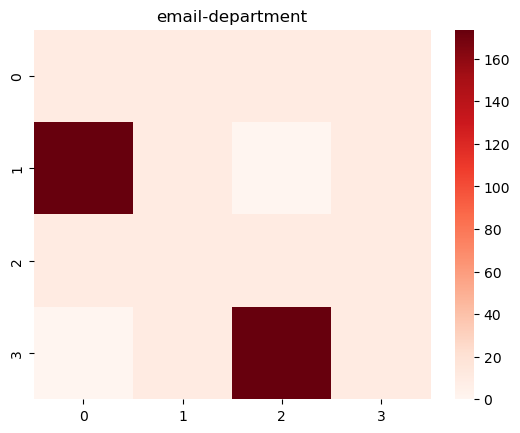

In [35]:
def plot(rules_list, support_data):
    row = []
    col = []
    length = len(rules_list)
    for item in rules_list:
        row.append(item[0])
        col.append(item[1])

    sim_lift = []
    sim_cosine = []
    for i in range(length):
        datarow_lift = []
        datarow_cosine = []
        for j in range(length):
            lift, cosine = calculate_lift_and_cosine(row[i], col[j], support_data)
            datarow_lift.append(lift)
            datarow_cosine.append(cosine)
        sim_lift.append(datarow_lift)
        sim_cosine.append(datarow_cosine)

    plt.title('email-department')
    sns.heatmap(sim_lift, cmap='Reds')
    plt.show()


plot(rules_list, support_data)
